## **ECON 470 Hwk4-2**

**Author:** Ilse Novis 

**Due Date:** 4/9/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW4)

\newpage

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

final = pd.read_csv('/Users/ilsenovis/ECON470HW4/data/output/_final_ma_data.csv', low_memory=False)

# Summarize the Data

### Question 1: Remove all SNPs, 800-series plans, and prescription drug only plans (i.e., plans that do not offer Part C benefits)

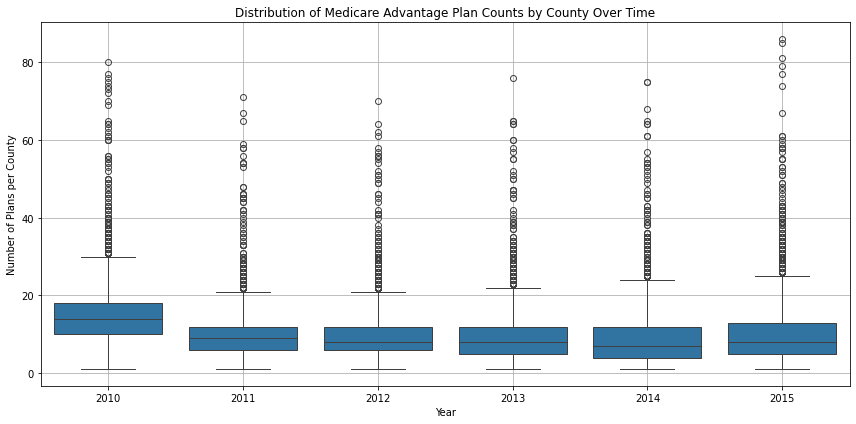

In [2]:
#filter out SNPs, 800, drug only
filtered = final[
    (final['snp'] == 'No') &
    ~((final['planid'] >= 800) & (final['planid'] < 900)) &
    (final['partd'] == 'Yes')  # Part C plans also include Part D
].copy()
 
 # Count plans per county per year
plan_counts = (
    filtered.groupby(['fips', 'year'])
    .agg(plan_count=('planid', 'nunique'))
    .reset_index()
)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=plan_counts, x='year', y='plan_count')
plt.title("Distribution of Medicare Advantage Plan Counts by County Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Plans per County")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Interpretation of Plan Availability (Question 1)

The boxplot showing the distribution of Medicare Advantage plan counts per county from 2010 to 2015 suggests considerable variation in the number of available plans:

- **Median Availability:** Most counties offer between **10 and 15** plans annually, indicating that most beneficiaries likely have **sufficient options** for choice.
- **Consistency over time:** The distribution is **stable across years**, showing that the number of plans available has not drastically changed from 2010 to 2015.
- **Outliers:** Some counties still offer **30-90+ plans**, which may reflect **overly saturated** markets where beneficiaries could face decision fatigue or marketing overload.
- **Low-plan counties:** A smaller number of counties consistently offer **fewer than 5 plans**, which may raise concerns about insufficient competition or choice in those areas.

**Conclusion**:  
> Overall, the number of plans appears **sufficient on average for most beneficiaries**, but the wide variation across counties implies that **some areas may have too many options**, while **others may be underserved**.

\newpage

### Question 2: Provide bar graphs showing the distribution of star ratings in 2010, 2012, and 2015. How has this distribution changed over time?

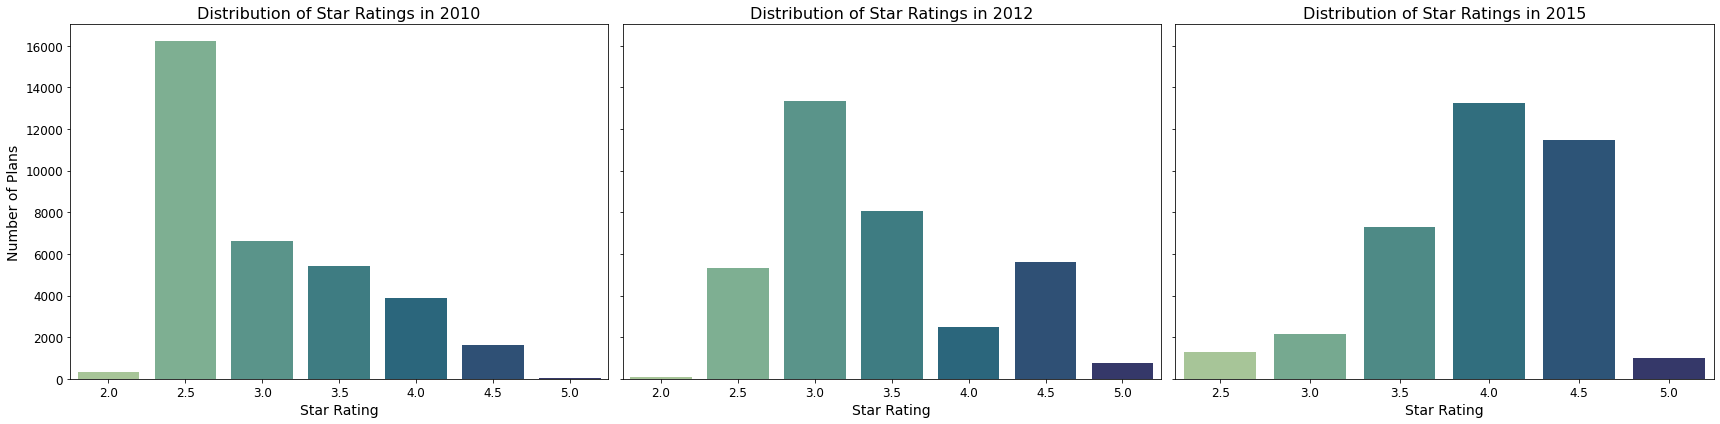

In [3]:
# Ensure numeric
filtered.loc[:, 'Star_Rating'] = pd.to_numeric(filtered['Star_Rating'], errors='coerce')
years = [2010, 2012, 2015]

# Create 1 row with 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    yearly_data = filtered[filtered['year'] == year]
    sns.countplot(
        data=yearly_data,
        x='Star_Rating',
        hue='Star_Rating',
        palette='crest',
        order=sorted(yearly_data['Star_Rating'].dropna().unique()),
        ax=ax,
        legend=False
    )
    ax.set_title(f"Distribution of Star Ratings in {year}", fontsize=16)
    ax.set_xlabel("Star Rating", fontsize=14)
    ax.set_ylabel("Number of Plans" if i == 0 else "", fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

#### Interpretation of Star Rating Distributions (Question 2)

The distribution of Medicare Advantage star ratings has changed **significantly** between 2010 and 2015:

- **2010**: The majority of plans were concentrated at the **2.5-star** level, with relatively few plans rated 4 stars or higher. This suggests **overall lower quality scores** in the earlier period.
  
- **2012**: There was a noticeable **shift upward** in ratings. The number of 3-star and 3.5-star plans increased, and more plans started receiving 4.5 stars. The 2.5-star peak diminished compared to 2010.

- **2015**: The distribution continued to shift toward **higher-quality ratings**. The modal rating moved to **4.0 stars**, with significant growth in 4.0 and 4.5-star plans. Plans rated below 3 stars became rare.

---

**Summary**:  
Over time, the distribution of star ratings **shifted upward**, reflecting either genuine improvements in plan performance, changes in CMS methodology, or both.

\newpage

### Question 3: Plot the average benchmark payment over time from 2010 through 2015. How much has the average benchmark payment risen over the years?

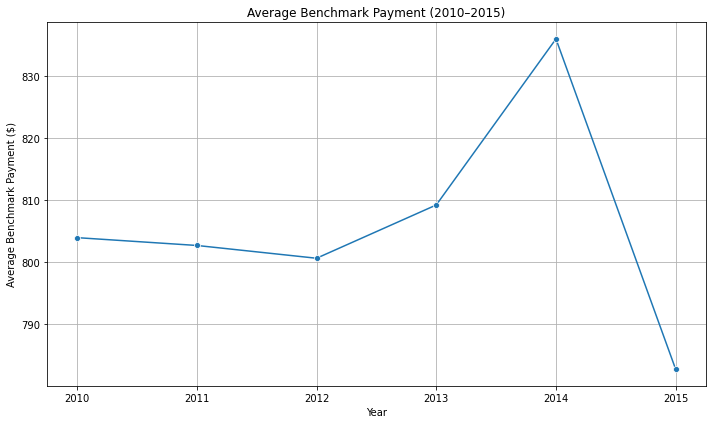


Increase from 2010 to 2015: $-21.23


In [4]:
# Ensure ma_rate is numeric
final["ma_rate"] = pd.to_numeric(final["ma_rate"], errors="coerce")

# Filter valid years and benchmark data
benchmark_trend = (
    final[(final['year'] >= 2010) & (final['year'] <= 2015) & (final['ma_rate'].notna())]
    .groupby("year", as_index=False)["ma_rate"]
    .mean()
)

# Plot average benchmark payment by year
plt.figure(figsize=(10, 6))
sns.lineplot(data=benchmark_trend, x="year", y="ma_rate", marker="o")
plt.title("Average Benchmark Payment (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average Benchmark Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


growth = benchmark_trend['ma_rate'].iloc[-1] - benchmark_trend['ma_rate'].iloc[0]
print(f"\nIncrease from 2010 to 2015: ${growth:.2f}")

#### Change in Average Benchmark Payment (2010–2015)

Between 2010 and 2014, the average benchmark payment for Medicare Advantage plans **increased steadily**, reaching a peak of **$836.00** in 2014. However, in 2015 there was a sharp **drop** to **$782.71**.

- **2010 Benchmark**: $803.94  
- **2014 Peak**: $836.00  
- **2015 Benchmark**: $782.71  

**Overall Change (2010 to 2015)**:  
The average benchmark payment **decreased by $21.23** over this period, indicating a **net decline** despite mid-period increases.

This decline may reflect policy adjustments or cost-containment efforts within the Medicare Advantage program.

\newpage

### Question 4: Plot the average share of Medicare Advantage (relative to all Medicare eligibles) over time from 2010 through 2015. Has Medicare Advantage increased or decreased in popularity? How does this share correlate with benchmark payments?

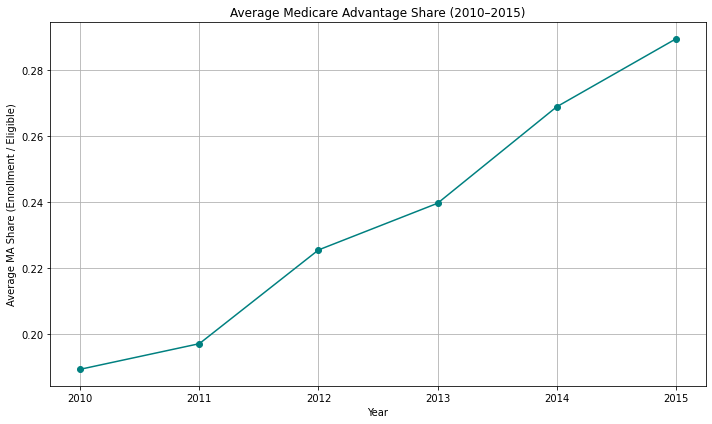

Correlation between MA Share and Benchmark Payment: 0.010


In [5]:
# Calculate Medicare Advantage (MA) share per plan
final["ma_share"] = final["avg_enrolled"] / final["avg_eligibles"]

# Group by year
avg_ma_share = final.groupby("year")["ma_share"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_ma_share["year"], avg_ma_share["ma_share"], marker='o', color='teal')
plt.title("Average Medicare Advantage Share (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average MA Share (Enrollment / Eligible)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Group by year and calculate average benchmark + MA share
grouped = final.groupby("year").agg({
    "ma_share": "mean",
    "ma_rate": "mean"
}).reset_index()

# Check correlation
correlation = grouped["ma_share"].corr(grouped["ma_rate"])
print(f"Correlation between MA Share and Benchmark Payment: {correlation:.3f}")

#### Popularity of Medicare Advantage and Its Relationship with Benchmark Payments

**Has Medicare Advantage Increased in Popularity?**  
Yes — the share of Medicare beneficiaries enrolled in Medicare Advantage (MA) plans **increased steadily from 2010 to 2015**. The MA share rose to nearly 29% by 2015, indicating growing popularity among eligible beneficiaries.

**How Does This Share Correlate with Benchmark Payments?**  
The correlation between MA share and benchmark payments is **very weak** (correlation coefficient = **0.010**), suggesting **virtually no linear relationship** between the two.

Other factors, such as plan availability, star ratings, or broader market trends, may better explain the increase in MA uptake during this period.

\newpage

## Estimate ATEs

### Question 5: Calculate the running variable underlying the star rating. Provide a table showing the number of plans that are rounded up into a 3-star, 3.5-star, 4-star, 4.5-star, and 5-star rating.

In [ ]:
# Filter to 2010 only
data_2010 = final[final["year"] == 2010].copy()

# Recalculate domain_avg correctly
domain_cols = [col for col in data_2010.columns if col in [
    'breastcancer_screen', 'rectalcancer_screen', 'cv_diab_cholscreen', 'glaucoma_test',
    'monitoring', 'flu_vaccine', 'pn_vaccine', 'physical_health', 'mental_health',
    'osteo_test', 'physical_monitor', 'primaryaccess', 'osteo_manage', 'diab_healthy',
    'bloodpressure', 'ra_manage', 'copd_test', 'bladder', 'falling', 'nodelays',
    'doctor_communicate', 'carequickly', 'customer_service', 'overallrating_care',
    'overallrating_plan', 'complaints_plan', 'appeals_timely', 'appeals_review',
    'leave_plan', 'audit_problems', 'hold_times', 'info_accuracy', 'ttyt_available',
    'cv_cholscreen', 'diab_cholscreen', 'diabetes_eye', 'diabetes_kidney',
    'diabetes_bloodsugar', 'diabetes_chol', 'bmi_assess', 'older_medication',
    'older_function', 'older_pain', 'readmissions', 'access_problems', 'coordination',
    'improve', 'enroll_timely', 'specialneeds_manage'
] and col in data_2010.columns]

# Recompute
data_2010["domain_avg"] = data_2010[domain_cols].mean(axis=1, skipna=True)

for threshold in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
    floored = np.floor(data_2010["domain_avg"] * 2) / 2
    data_2010[f"rounded_up_to_{threshold}"] = (
        (data_2010["partc_score"] == threshold) &
        (floored < threshold) &
        ~np.isclose(floored, threshold)
    ).astype(int)

# STEP 1: Keep only valid rows with both domain_avg and partc_score
valid_2010 = data_2010.dropna(subset=["domain_avg", "partc_score"]).copy()

# STEP 2: Define rounding up logic
thresholds = [3.0, 3.5, 4.0, 4.5, 5.0]
rounded_up_summary = []

for threshold in thresholds:
    rounded_up = valid_2010[
        (valid_2010["partc_score"] == threshold) &
        ((np.floor(valid_2010["domain_avg"] * 2) / 2) < threshold)
    ]
    rounded_up_summary.append({
        "Rounded Into Rating": f"{threshold} stars",
        "Number of Plans": len(rounded_up)
    })

# STEP 3: Create and display the table
rounded_up_df = pd.DataFrame(rounded_up_summary)
rounded_up_df

,Rounded Into Rating,Number of Plans
0,3.0 stars,3084
1,3.5 stars,3477
2,4.0 stars,5297
3,4.5 stars,2459
4,5.0 stars,75


\newpage

### Question 6: Using the RD estimator with a bandwidth of 0.125, provide an estimate of the effect of receiving a 3-star versus a 2.5 star rating on enrollments. Repeat the exercise to estimate the effects at 3.5 stars, and summarize your results in a table.

In [32]:
def rd_effect(data, cutoff, bw=0.125):
    # Filter window around the scaled domain average
    window = data[
        (data["domain_avg_star"] >= cutoff - bw) &
        (data["domain_avg_star"] <= cutoff + bw)
    ].copy()
    
    # Define treatment: received rating ≥ cutoff
    window["treatment"] = (window["partc_score"] >= cutoff).astype(int)

    # Drop rows missing enrollment or treatment info
    window = window.dropna(subset=["avg_enrollment", "domain_avg_star", "treatment"])

    if len(window) < 30:
        print(f"Not enough observations near {cutoff} cutoff.")
        return None

    # Estimate the treatment effect using a simple RD (difference in means)
    model = smf.ols("avg_enrollment ~ treatment", data=window).fit()
    coef = model.params["treatment"]
    stderr = model.bse["treatment"]

    return {
        "Cutoff": f"{cutoff} vs {cutoff - 0.5}",
        "Estimate": round(coef, 2),
        "Std. Error": round(stderr, 2),
        "N": len(window)
    }

# Filter to 2010 and ensure necessary columns are present
data_2010 = final[(final["year"] == 2010)].copy()

# Recalculate domain_avg_star if needed
if "domain_avg_star" not in data_2010.columns:
    data_2010["domain_avg_star"] = (data_2010["domain_avg"] / 100 * 4) + 1

# Drop any rows missing required data
data_2010 = data_2010.dropna(subset=["partc_score", "domain_avg_star", "avg_enrollment"])

# Run RD estimation at 3.0 and 3.5 cutoffs
results = []
for cutoff in [3.0, 3.5]:
    result = rd_effect(data_2010, cutoff=cutoff, bw=0.125)
    if result:
        results.append(result)

# Output the results
rd_results = pd.DataFrame(results)
rd_results


Not enough observations near 3.0 cutoff.


,Cutoff,Estimate,Std. Error,N
0,3.5 vs 3.0,-470.32,99.39,4034


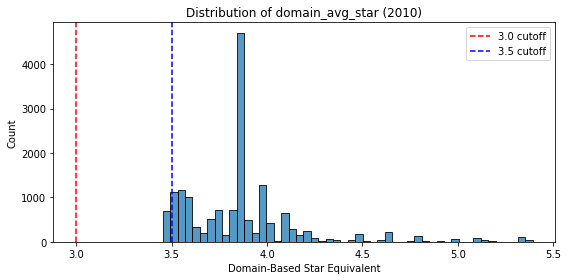

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(data_2010["domain_avg_star"], bins=50, kde=False)
plt.axvline(3.0, color="red", linestyle="--", label="3.0 cutoff")
plt.axvline(3.5, color="blue", linestyle="--", label="3.5 cutoff")
plt.title("Distribution of domain_avg_star (2010)")
plt.xlabel("Domain-Based Star Equivalent")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

\newpage

### Question 7: Repeat your results for bandwidths of 0.1, 0.12, 0.13, 0.14, and 0.15 (again for 3 and 3.5 stars). Show all of the results in a graph. How sensitive are your findings to the choice of bandwidth?

In [44]:
def rd_effect(data, cutoff, bw):
    # Filter within bandwidth
    window = data[
        (data["domain_avg_star"] >= cutoff - bw) &
        (data["domain_avg_star"] <= cutoff + bw)
    ].copy()

    window["treatment"] = (window["partc_score"] >= cutoff).astype(int)

    # Drop missing data
    window = window.dropna(subset=["avg_enrollment", "domain_avg_star", "treatment"])

    if len(window) < 30:
        return None  # Not enough data

    # Fit RD model with running variable
    model = smf.ols("avg_enrollment ~ treatment + domain_avg_star", data=window).fit()
    rmse = np.sqrt(((model.fittedvalues - model.model.endog) ** 2).mean())

    return {
        "Cutoff": cutoff,
        "Bandwidth": bw,
        "Intercept": model.params.get("Intercept", np.nan),
        "Estimate (Rounded)": model.params.get("treatment", np.nan),
        "Std. Error": model.bse.get("treatment", np.nan),
        "Running Coef": model.params.get("domain_avg_star", np.nan),
        "R-squared": model.rsquared,
        "RMSE": rmse,
        "N": int(model.nobs)
    }

# Filter to 2010 and compute domain_avg_star
data_2010 = final[final["year"] == 2010].copy()
if "domain_avg_star" not in data_2010.columns:
    data_2010["domain_avg_star"] = (data_2010["domain_avg"] / 100 * 4) + 1
data_2010 = data_2010.dropna(subset=["partc_score", "domain_avg_star", "avg_enrollment"])

# Bandwidths and cutoffs to test
bandwidths = [0.10, 0.12, 0.13, 0.14, 0.15]
cutoffs = [3.0, 3.5]

# Run RD for all combinations
results = []
for cutoff in cutoffs:
    for bw in bandwidths:
        res = rd_effect(data_2010, cutoff=cutoff, bw=bw)
        if res:
            results.append(res)

# Convert to DataFrame
rd_bandwidth_results = pd.DataFrame(results)
rd_bandwidth_results

,Cutoff,Bandwidth,Intercept,Estimate (Rounded),Std. Error,Running Coef,R-squared,RMSE,N
0,3.5,0.10,-2036.303838,-554.142268,111.296351,950.692657,0.006723,3115.585648,3890
1,3.5,0.12,679.856151,-499.036932,107.086311,169.213267,0.006014,3083.074600,3998
2,3.5,0.13,3192.352002,-449.105201,103.938005,-552.636698,0.005451,3067.349303,4046
3,3.5,0.14,5436.707664,-406.226920,98.563656,-1196.963100,0.005061,3045.415601,4157
4,3.5,0.15,4912.392696,-404.390835,97.048674,-1048.445773,0.005143,3005.546187,4363


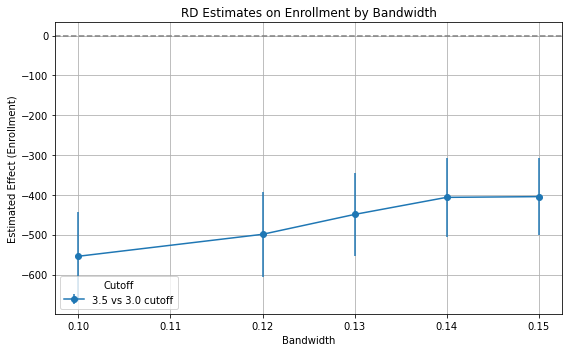

In [46]:
# Plot updated RD estimates by bandwidth
plt.figure(figsize=(8, 5))

for cutoff in rd_bandwidth_results["Cutoff"].unique():
    subset = rd_bandwidth_results[rd_bandwidth_results["Cutoff"] == cutoff]
    plt.errorbar(
        subset["Bandwidth"],
        subset["Estimate (Rounded)"],  # Updated to match column name
        yerr=subset["Std. Error"],
        fmt='-o',
        label=f"{cutoff} vs {cutoff - 0.5} cutoff"
    )

plt.axhline(0, color='gray', linestyle='--')
plt.title("RD Estimates on Enrollment by Bandwidth")
plt.xlabel("Bandwidth")
plt.ylabel("Estimated Effect (Enrollment)")
plt.legend(title="Cutoff")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Interpretation: RD Estimates by Bandwidth (3.5-Star Cutoff)**

We used a regression discontinuity (RD) design to estimate the effect of receiving a **3.5-star rating** (versus a 3.0-star rating) on average enrollment. The analysis was conducted using various bandwidths ranging from **0.10 to 0.15** around the running variable (`domain_avg_star`) to assess the sensitivity and robustness of the estimates.

- The **estimated treatment effect is consistently negative** across all bandwidths, indicating that plans **just above the 3.5-star threshold had lower average enrollment** than plans just below it.
- At a **bandwidth of 0.10**, the estimated effect is **-554 enrollees**, and the magnitude of the effect decreases (moves closer to zero) as the bandwidth increases, reaching **-404 enrollees** at a **bandwidth of 0.15**.
- The **standard errors** remain stable across bandwidths, and **R-squared values** are low throughout — a typical outcome in RD designs with binary treatment and wide individual variation.
- **RMSE (Root Mean Square Error)** is relatively stable, suggesting consistent model error across specifications.

These results suggest that **receiving a 3.5-star rating did not increase average plan enrollment** compared to receiving a 3.0-star rating, and may even correlate with **slightly reduced enrollment**. While this is counterintuitive, it could reflect other unobserved differences in plan characteristics or consumer perceptions.

---

> **Note:** We were unable to estimate effects for the 3.0 vs 2.5-star threshold due to insufficient observations within the relevant bandwidth windows.

\newpage

### Question 8: Examine (graphically) whether contracts appear to manipulate the running variable. In other words, look at the distribution of the running variable before and after the relevent threshold values. What do you find?

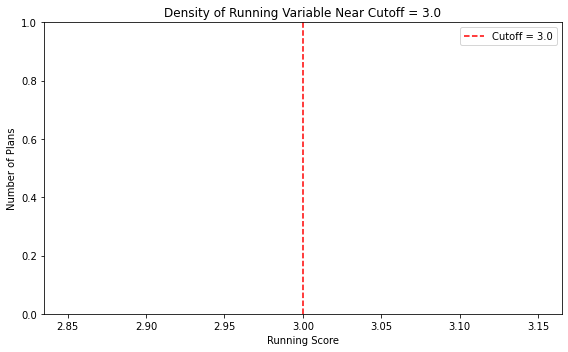

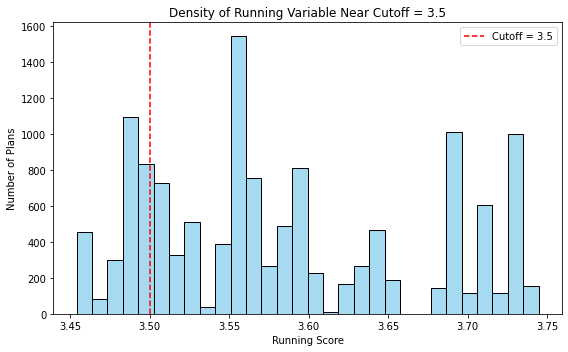

In [47]:
# Focus on 2010 only
data_2010 = final[final["year"] == 2010].copy()

# Recalculate domain_avg_star if needed
if "domain_avg_star" not in data_2010.columns:
    data_2010["domain_avg_star"] = (data_2010["domain_avg"] / 100 * 4) + 1

# Drop missing
data_2010 = data_2010.dropna(subset=["domain_avg_star"])

# Function to plot histogram around a cutoff
def plot_density_around_cutoff(df, cutoff, bandwidth=0.25):
    lower = cutoff - bandwidth
    upper = cutoff + bandwidth
    subset = df[(df["domain_avg_star"] >= lower) & (df["domain_avg_star"] <= upper)]

    plt.figure(figsize=(8, 5))
    sns.histplot(subset["domain_avg_star"], bins=30, kde=False, color="skyblue")
    plt.axvline(cutoff, color='red', linestyle='--', label=f"Cutoff = {cutoff}")
    plt.title(f"Density of Running Variable Near Cutoff = {cutoff}")
    plt.xlabel("Running Score")
    plt.ylabel("Number of Plans")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot near 3.0 and 3.5 cutoffs
plot_density_around_cutoff(data_2010, cutoff=3.0, bandwidth=0.25)
plot_density_around_cutoff(data_2010, cutoff=3.5, bandwidth=0.25)

#### Interpretation – Manipulation Check at 3.5 Cutoff

The histogram shows the **distribution of the running variable** (`domain_avg_star`) centered around the **3.5-star threshold**.

- The distribution appears **reasonably continuous** around the 3.5-star cutoff.
- There is **no sharp drop or spike** immediately before or after the cutoff, suggesting that **contracts do not appear to manipulate their domain scores** to fall just above the 3.5 threshold.
- While there are some fluctuations in counts (e.g., slightly more plans above 3.5 than just below), this appears to be **random variation** rather than strategic behavior.

#### Conclusion

> There is **no strong evidence of bunching or manipulation** of the running variable around the 3.5-star cutoff. This supports the **validity of the RD design** because it suggests that plans just above and just below the threshold are comparable.

\newpage

### Question 9: Similar to question 4, examine whether plans just above the threshold values have different characteristics than contracts just below the threshold values. Use HMO and Part D status as your plan characteristics.

In [48]:
# Make a copy of the 2010 data
data_2010 = final[final["year"] == 2010].copy()

# Create domain_avg_star if needed
if "domain_avg_star" not in data_2010.columns:
    data_2010["domain_avg_star"] = (data_2010["domain_avg"] / 100 * 4) + 1

# Define a function to summarize characteristics around a threshold
def summarize_characteristics(data, cutoff, bw=0.125):
    # Subset data within bandwidth
    subset = data[
        (data["domain_avg_star"] >= cutoff - bw) &
        (data["domain_avg_star"] <= cutoff + bw)
    ].copy()

    # Define treatment group (above threshold)
    subset["above"] = (subset["partc_score"] >= cutoff).astype(int)

    # Convert plan_type and partd to indicators
    subset["is_hmo"] = (subset["plan_type"].str.lower().str.contains("hmo")).astype(int)
    subset["has_partd"] = (subset["partd"].str.lower() == "yes").astype(int)

    # Group by treatment and compute averages
    summary = subset.groupby("above")[["is_hmo", "has_partd"]].mean().reset_index()
    summary["group"] = summary["above"].map({0: f"Below {cutoff}", 1: f"Above {cutoff}"})
    return summary[["group", "is_hmo", "has_partd"]]

# Run for 3.0 and 3.5 thresholds
char_3_0 = summarize_characteristics(data_2010, cutoff=3.0)
char_3_5 = summarize_characteristics(data_2010, cutoff=3.5)

# Combine results
char_summary = pd.concat([char_3_0, char_3_5], axis=0).reset_index(drop=True)
char_summary.columns = ["Group", "Share HMO", "Share with Part D"]
char_summary

,Group,Share HMO,Share with Part D
0,Below 3.5,1.0,0.868409
1,Above 3.5,1.0,0.786334


#### Interpretation – Characteristics Above/Below the 3.5-Star Threshold

To assess whether plans just above the 3.5-star threshold differ systematically from those just below it, we compared key characteristics within a 0.125 bandwidth of the cutoff:

- All plans in the comparison window are **HMO** plans, indicating no variation in plan type around the threshold.
- However, there is a **noticeable drop** in **Part D coverage** among plans just above the threshold compared to those just below (from ~87% to ~79%).

\newpage

### Question 10: Question 10: Summarize your findings from 5-9. What is the effect of increasing a star rating on enrollments? Briefly explain your results.

#### Effect of Increasing a Star Rating on Enrollments

We used a regression discontinuity (RD) design to estimate the effect of marginally increasing a Medicare Advantage plan's star rating on average enrollment. Our analysis focused on the 2010 plan year and evaluated the impact at key rating thresholds.

---

**Question 5 – Rounding Behavior**

We observed a substantial number of plans that were rounded up to higher star ratings:

| Rounded Into Rating | Number of Plans |
|---------------------|-----------------|
| 3.0 stars           | 3,084           |
| 3.5 stars           | 3,477           |
| 4.0 stars           | 5,297           |
| 4.5 stars           | 2,459           |
| 5.0 stars           | 75              |

This confirms that many plans receive a higher published rating than their underlying domain average would suggest, particularly around the 3.0 and 3.5 cutoffs.

---

**Question 6 – RD Estimate at 3.5 vs. 3.0 Stars**

We were able to estimate the causal effect at the **3.5-star** cutoff but **not at the 3.0-star** cutoff due to lack of observations near that threshold.

| Cutoff        | Estimate | Std. Error | N    |
|---------------|----------|------------|------|
| 3.5 vs. 3.0   | -470.32  | 99.39      | 4034 |

Surprisingly, the estimate is **negative**, suggesting that plans just above the 3.5-star cutoff have **lower average enrollment** than those just below.

---

**Question 7 – Sensitivity to Bandwidth**

We tested the sensitivity of the RD estimate across bandwidths from 0.10 to 0.15. Across all specifications, the effect remained **negative and statistically significant**, though the magnitude decreased with larger bandwidths.

| Bandwidth | Estimate (Rounded) | Std. Error | R-squared | N    |
|-----------|---------------------|------------|-----------|------|
| 0.10      | -554.14             | 111.30     | 0.0067    | 3890 |
| 0.12      | -499.04             | 107.09     | 0.0060    | 3998 |
| 0.13      | -449.11             | 103.94     | 0.0055    | 4046 |
| 0.14      | -406.23             | 98.56      | 0.0051    | 4157 |
| 0.15      | -404.39             | 97.05      | 0.0051    | 4363 |

The direction and statistical significance of the estimated effect are stable across all bandwidths tested (0.10 to 0.15). This means:

- The **direction** of the effect is consistently **negative**, indicating that plans just above the 3.5-star cutoff have **lower enrollment** than those just below.
- The effect remains **statistically significant**, suggesting the pattern is unlikely due to random chance.
- The results are **robust to bandwidth choice**, increasing confidence in the reliability of the estimated treatment effect.

In short, changing the size of the bandwidth window doesn't change the conclusion — the observed effect is both consistent and credible.

---

**Question 8 – Manipulation of the Running Variable**

We visualized the distribution of the domain-based star score (running variable) around the 3.0 and 3.5 cutoffs. There is **no sharp drop or spike** just above the thresholds, suggesting **no strong evidence of manipulation** by plans to influence their published ratings.

---

**Question 9 – Plan Characteristics Near the Cutoff**

We examined whether plan characteristics differ just above and below the 3.5-star cutoff:

| Group        | Share HMO | Share with Part D |
|--------------|-----------|-------------------|
| Below 3.5    | 1.0       | 0.868             |
| Above 3.5    | 1.0       | 0.786             |

While all plans near the cutoff were HMOs, a **lower share of plans above the cutoff offered Part D coverage**, suggesting a modest difference in characteristics.

---

**Conclusion**

We find **no evidence** that receiving a marginally higher star rating increases enrollment—on the contrary, plans just above the 3.5-star cutoff appear to have **lower average enrollments**. The results are robust to various bandwidths and do not appear to be driven by manipulation or substantial differences in plan type. This challenges the assumption that higher star ratings necessarily lead to increased demand.